In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
nielmirafuentes_exp_dataset_path = kagglehub.dataset_download('nielmirafuentes/exp-dataset')

print('Data source import complete.')


nielmirafuentes_exp_dataset_path = f"{nielmirafuentes_exp_dataset_path}/ChatGPT_Rationales_file_REDDIT_dataset(90-10).csv"


100%|██████████| 2.78M/2.78M [00:00<00:00, 69.3MB/s]

Extracting files...
Data source import complete.


In [ ]:
print(nielmirafuentes_exp_dataset_path)

/root/.cache/kagglehub/datasets/nielmirafuentes/exp-dataset/versions/1/ChatGPT_Rationales_file_REDDIT_dataset(90-10).csv


In [ ]:
!pip install -q transformers datasets evaluate tensorflow tensorflow_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.0 MB/s eta 0:00:00


In [ ]:
import os
import gc
import re
import math
import random
from typing import List, Tuple
from collections import defaultdict
from sklearn.model_selection import train_test_split
import argparse


import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    precision_recall_fscore_support,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    jaccard_score,
    roc_auc_score
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow_hub as hub


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from transformers import AutoTokenizer, AutoModel, AutoModelForMaskedLM, get_linear_schedule_with_warmup
from torch.optim import AdamW
from typing import Optional, Tuple, List, Dict

os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [ ]:

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [ ]:
class AdditionalCustomDataset(Dataset):
    def __init__(self, texts, labels, rationales, tokenizer, bert_tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.rationales = rationales
        self.tokenizer = tokenizer            # tokenizer for HateBERT (original text)
        self.bert_tokenizer = bert_tokenizer  # tokenizer for rationale text
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        rationale_text = str(self.rationales[idx]) if (self.rationales is not None) else ""
        label = int(self.labels[idx])

        enc = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt',
            return_attention_mask=True
        )
        add_enc = self.bert_tokenizer(
            rationale_text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt',
            return_attention_mask=True
        )

        input_ids = enc['input_ids'].squeeze(0)
        attention_mask = enc['attention_mask'].squeeze(0)
        additional_input_ids = add_enc['input_ids'].squeeze(0)
        additional_attention_mask = add_enc['attention_mask'].squeeze(0)

        # Build token-level rationale mask by token-string overlap
        orig_tokens = self.tokenizer.convert_ids_to_tokens(input_ids.tolist())
        rat_tokens = set([t for t in self.bert_tokenizer.convert_ids_to_tokens(additional_input_ids.tolist()) if t not in (self.bert_tokenizer.pad_token, None)])
        rationale_mask = torch.zeros(self.max_length, dtype=torch.float)
        for i, tok in enumerate(orig_tokens):
            if i >= self.max_length:
                break
            if tok in rat_tokens and tok not in (self.tokenizer.pad_token, None):
                rationale_mask[i] = 1.0

        # ensure we don't mark PAD positions
        pad_id = self.tokenizer.pad_token_id
        if pad_id is not None:
            pad_positions = (input_ids == pad_id).nonzero(as_tuple=True)[0]
            for p in pad_positions:
                rationale_mask[p] = 0.0

        return input_ids, attention_mask, additional_input_ids, additional_attention_mask, torch.tensor(label, dtype=torch.long), rationale_mask

In [ ]:
class ProjectionMLP(nn.Module):
    def __init__(self, input_size, hidden_size=256, num_labels=2):
        super(ProjectionMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_labels)
        )
    def forward(self, x):
        return self.layers(x)

In [ ]:
class BasaeShield(nn.Module):
    def __init__(self,
                 hatebert_model,
                 additional_model,
                 projection_mlp,
                 hidden_size=768,
                 freeze_additional_model=True,
                 device='cpu'):
        super().__init__()
        self.hatebert_model = hatebert_model
        self.additional_model = additional_model
        self.projection_mlp = projection_mlp
        self.device = device

        # freeze additional_model if requested
        if freeze_additional_model:
            for param in self.additional_model.parameters():
                param.requires_grad = False



    def forward(self, input_ids, attention_mask, additional_input_ids, additional_attention_mask, return_attentions=False):
        # Main text through HateBERT
        hatebert_out = self.hatebert_model(input_ids=input_ids,
                                           attention_mask=attention_mask,
                                           output_attentions=return_attentions,
                                           return_dict=True)
        hatebert_emb = hatebert_out.last_hidden_state[:, 0, :]                 # (B, H)
        hatebert_embeddings = torch.nn.LayerNorm(hatebert_emb.size()[1:]).to(self.device)(hatebert_emb.to(self.device)).to(self.device)

        # Rationale text through frozen BERT
        with torch.no_grad():
            add_out = self.additional_model(input_ids=additional_input_ids,
                                            attention_mask=additional_attention_mask,
                                            return_dict=True)
            rationale_emb = add_out.last_hidden_state[:, 0, :]                 # (B, H)
            rationale_embeddings = torch.nn.LayerNorm(rationale_emb.size()[1:]).to(self.device)(rationale_emb.to(self.device)).to(self.device)
        # concat CLS + CNN features + pooled rationale
        concat_emb = torch.cat((hatebert_embeddings, rationale_embeddings), dim=1)

        logits = self.projection_mlp(concat_emb)

        return logits

In [ ]:
import matplotlib.pyplot as plt

def plot_two_arrays(arr1, arr2, label1, label2, title="My Plot"):
    plt.figure(figsize=(8, 4))

    plt.plot(arr1, label=label1, color='red')
    plt.plot(arr2, label=label2, color='blue')

    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [ ]:
class EarlyStopping:
    """
    Early stopping to stop training when validation loss doesn't improve.
    """
    def __init__(self, patience=10, min_delta=1.0, mode='max', verbose=True):
        """
        Args:
            patience (int): How many epochs to wait after last improvement.
            min_delta (float): Minimum change to qualify as an improvement.
            mode (str): 'min' for loss, 'max' for accuracy/f1.
            verbose (bool): Print messages when improvement occurs.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, current_score, model):
        """
        Call this after each epoch with the validation metric and model.

        Args:
            current_score: Current epoch's validation metric (loss, accuracy, f1, etc.)
            model: The model to save if there's improvement

        Returns:
            bool: True if training should stop, False otherwise
        """
        if self.best_score is None:
            # First epoch
            self.best_score = current_score
            self.save_checkpoint(model)
            if self.verbose:
                print(f"Initial best score: {self.best_score:.4f}")
        else:
            # Check if there's improvement
            if self.mode == 'min':
                improved = current_score < (self.best_score - self.min_delta)
            else:  # mode == 'max'
                improved = current_score > (self.best_score + self.min_delta)

            if improved:
                self.best_score = current_score
                self.save_checkpoint(model)
                self.counter = 0
                if self.verbose:
                    print(f"Validation improved! New best score: {self.best_score:.4f}")
            else:
                self.counter += 1
                if self.verbose:
                    print(f"No improvement. Patience counter: {self.counter}/{self.patience}")

                if self.counter >= self.patience:
                    self.early_stop = True
                    if self.verbose:
                        print(f"Early stopping triggered! Best score: {self.best_score:.4f}")

        return self.early_stop

    def save_checkpoint(self, model):
        """Save model state dict"""
        import copy
        self.best_model_state = copy.deepcopy(model.state_dict())

    def load_best_model(self, model):
        """Load the best model state into the model"""
        if self.best_model_state is not None:
            model.load_state_dict(self.best_model_state)
            if self.verbose:
                print(f"Loaded best model with score: {self.best_score:.4f}")
        return model

In [ ]:
def train_and_evaluate(reddit_csv_path,
                       hatebert_model,
                       rationale_model,
                       tokenizer_hatebert,
                       tokenizer_rationale,
                       epochs=100,
                       batch_size=16,
                       lr=3e-5,
                       seed=42,
                       max_length=128,
                       freeze_rationale=True,
                       cnn_num_filters=128,
                       cnn_kernel_sizes=(2,3,4),
                       cnn_dropout=0.3,
                       adapter_dim=128,
                       classifier_type="multihead",
                       show_visualizations=5,
                       weight_decay=0.0,
                       device=None,
                        use_early_stopping=True, patience=3,
                       early_stop_metric='loss', min_delta=0.001):
    """
    Train and evaluate the ConcatModelWithRationale pipeline on a dataset CSV.
    """
    set_seed(seed)
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    print("Device:", device)

    # Load dataset
    df = pd.read_csv(reddit_csv_path)
    train_df = df[df['exp_split'] == 'train'].reset_index(drop=True)
    test_df = df[df['exp_split'] == 'test'].reset_index(drop=True)

    print("Train df:", len(train_df))
    print("Test df:", len(test_df))

    # Extract texts, labels, and rationales
    train_texts = train_df['text'].tolist()
    train_labels = train_df['label'].tolist()
    train_rationales = train_df['ChatGPT_Rationales'].tolist() if 'ChatGPT_Rationales' in train_df.columns else [""]*len(train_df)

    test_texts = test_df['text'].tolist()
    test_labels = test_df['label'].tolist()
    test_rationales = test_df['ChatGPT_Rationales'].tolist() if 'ChatGPT_Rationales' in test_df.columns else [""]*len(test_df)

    # Optional: create validation set from training data (e.g., 10% of train)
    val_size = int(0.2 * len(train_texts))
    val_texts = train_texts[:val_size]
    val_labels = train_labels[:val_size]
    val_rationales = train_rationales[:val_size]

    tr_texts = train_texts[val_size:]
    tr_labels = train_labels[val_size:]
    tr_rationales = train_rationales[val_size:]

    # Datasets and DataLoaders
    train_dataset = AdditionalCustomDataset(tr_texts, tr_labels, tr_rationales,
                                            tokenizer_hatebert, tokenizer_rationale, max_length)
    val_dataset = AdditionalCustomDataset(val_texts, val_labels, val_rationales,
                                          tokenizer_hatebert, tokenizer_rationale, max_length)
    test_dataset = AdditionalCustomDataset(test_texts, test_labels, test_rationales,
                                           tokenizer_hatebert, tokenizer_rationale, max_length)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    # Model
    H = hatebert_model.config.hidden_size
    dummy_hatebert = torch.zeros(1, max_length, H)
    dummy_rationale = torch.zeros(1, max_length, H)


    projection_mlp = ProjectionMLP(input_size=1536, hidden_size=512, num_labels=len(set(train_labels)))

    model = ConcatModelWithRationale(
        hatebert_model=hatebert_model,
        additional_model=rationale_model,
        projection_mlp=projection_mlp,
        hidden_size=H,
        freeze_additional_model=freeze_rationale,
        device=device
    ).to(device)

    optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss().to(device)

    if use_early_stopping:
        mode = 'min' if early_stop_metric == 'loss' else 'max'
        print(f"early stopping mode: {mode} on {early_stop_metric}")
        early_stopping = EarlyStopping(patience=patience, min_delta=min_delta,
                                      mode=mode, verbose=True)
        print(f"\nEarly stopping enabled: monitoring validation {early_stop_metric} "
              f"with patience={patience}, min_delta={min_delta}")

    train_loss = []
    val_loss = []

    val_precision = []
    val_accuracy = []
    val_f1=[]
    val_recall=[]

    train_f1 = []
    train_recall = []
    train_precision = []
    train_accuracy = []


    # Training
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        total_samples = 0
        correct = 0
        preds_arr,trues_arr = [] , []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            input_ids, attention_mask, add_input_ids, add_att_mask, labels, rat_mask = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            add_input_ids = add_input_ids.to(device)
            add_att_mask = add_att_mask.to(device)
            labels = labels.to(device)
            rat_mask = rat_mask.to(device)

            optimizer.zero_grad()
            logits = model(input_ids, attention_mask, add_input_ids, add_att_mask)
            # loss, cls_loss, sel_loss, _ = combined_loss(logits, labels, rationale_probs, selector_logits, rationale_mask=rat_mask)
            loss = criterion(logits.view(-1, 2), labels.view(-1))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            total_loss += loss.item()
            preds = logits.argmax(dim=1)
            total_samples += labels.size(0)
            correct += (preds == labels).sum().item()
            preds_arr.extend(preds.cpu().numpy().tolist())
            trues_arr.extend(labels.cpu().numpy().tolist())


        accuracy = accuracy_score(y_true=trues_arr, y_pred=preds_arr)
        precision = precision_score(y_true=trues_arr, y_pred=preds_arr)
        f1 = f1_score(y_true=trues_arr, y_pred=preds_arr)
        recall = recall_score(y_true=trues_arr, y_pred=preds_arr)
        epoch_train_loss = total_loss/len(train_loader)



        train_loss.append(epoch_train_loss)
        train_accuracy.append(accuracy)
        train_precision.append(precision)
        train_recall.append(recall)
        train_f1.append(f1)


        print('\n')
        print(f"Epoch {epoch+1}: Train Loss={epoch_train_loss:.4f} Accuracy={accuracy:.4f} Precision={precision:.4f} f1 score={f1:.4f} recall={recall:.4f}")

        # Validation
        model.eval()
        val_preds, val_labels_list = [], []
        validation_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids, attention_mask, add_input_ids, add_att_mask, labels, rat_mask = batch
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                add_input_ids = add_input_ids.to(device)
                add_att_mask = add_att_mask.to(device)
                labels = labels.to(device)
                rat_mask = rat_mask.to(device)

                logits = model(input_ids, attention_mask, add_input_ids, add_att_mask)
                loss = criterion(logits.view(-1, 2), labels.view(-1))
                validation_loss += loss.item()
                preds = logits.argmax(dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels_list.extend(labels.cpu().numpy())

        val_acc = accuracy_score(val_labels_list, val_preds)
        val_prec = precision_score(y_true=val_labels_list, y_pred=val_preds)
        val_f1_score = f1_score(y_true=val_labels_list, y_pred=val_preds)
        val_rec = recall_score(y_true=val_labels_list, y_pred=val_preds)
        epoch_val_loss = validation_loss /len(val_loader)

        val_loss.append(epoch_val_loss)
        val_accuracy.append(val_acc)
        val_precision.append(val_prec)
        val_f1.append(val_f1_score)
        val_recall.append(val_rec)
        print('\n')
        print(f"Validation Accuracy: {val_acc:.4f} Precision: {val_prec} f1: {val_f1_score} recall: {val_rec} loss: {epoch_val_loss}")
        if use_early_stopping:
            if early_stop_metric == 'loss':
                current_metric = epoch_val_loss
            elif early_stop_metric == 'accuracy':
                current_metric = val_acc
            elif early_stop_metric == 'f1':
                current_metric = val_f1_score
            elif early_stop_metric == 'precision':
                current_metric = val_prec
            elif early_stop_metric == 'recall':
                current_metric = val_rec
            else:
                raise ValueError(f"Unknown metric: {early_stop_metric}")

        if early_stopping(current_metric, model):
                print(f"\n{'='*50}")
                print(f"Early stopping at epoch {epoch+1}")
                print(f"{'='*50}\n")
                break
    if use_early_stopping:
        model = early_stopping.load_best_model(model)


    # Test
    model.eval()
    test_preds, test_labels_list = [], []
    saved_rationales = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, add_input_ids, add_att_mask, labels, _ = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            add_input_ids = add_input_ids.to(device)
            add_att_mask = add_att_mask.to(device)
            labels = labels.to(device)

            logits = model(input_ids, attention_mask, add_input_ids, add_att_mask)
            probs = logits.softmax(dim=1)
            preds = logits.argmax(dim=1)
            test_preds.extend(preds.cpu().numpy())
            test_labels_list.extend(labels.cpu().numpy())

    plot_two_arrays(train_loss, val_loss, "train loss", "validation loss", "loss over epochs")
    plot_two_arrays(train_accuracy, val_accuracy, "train accuracy", "validation accuracy", "accuracy over epoch")
    plot_two_arrays(train_precision, val_precision, "train precision", "validation precision", "precision over epoch")
    plot_two_arrays(train_f1, val_f1, "train f1", "validation f1", "f1 over epoch")
    plot_two_arrays(train_recall, val_recall, "train recall", "validation recall", "recall over epoch")

    # Metrics
    print(f"train loss: {train_loss}")
    print(f"validation loss: {val_loss}")
    test_acc = accuracy_score(test_labels_list, test_preds)
    test_precision = precision_score(y_true=test_labels_list, y_pred=test_preds)
    test_f1 = f1_score(y_true=test_labels_list, y_pred=test_preds)
    test_recall = recall_score(y_true=test_labels_list, y_pred=test_preds)
    print(f"\n=== Test Accuracy: {test_acc:.4f} ===")
    print(f"\n=== Test Precision: {test_precision:.4f} ===")
    print(f"\n=== Test f1: {test_f1:.4f} ===")
    print(f"\n=== Test recall: {test_recall:.4f} ===")
    print(classification_report(test_labels_list, test_preds, zero_division=0))
    print("Confusion Matrix:\n", confusion_matrix(test_labels_list, test_preds))

    # Visualize first few rationales



    return model

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/151 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Device: cuda
Train df: 33447
Test df: 3717
early stopping mode: min on loss

Early stopping enabled: monitoring validation loss with patience=3, min_delta=0.001


Epoch 1/6: 100%|██████████| 3345/3345 [14:00<00:00,  3.98it/s]



Epoch 1: Train Loss=0.3557 Accuracy=0.8582 Precision=0.8179 f1 score=0.8062 recall=0.7949




Validation Accuracy: 0.9146 Precision: 0.8614969135802469 f1: 0.8866388723446496 recall: 0.9132924335378323 loss: 0.25046865694701065
Initial best score: 0.2505


Epoch 2/6: 100%|██████████| 3345/3345 [13:57<00:00,  3.99it/s]



Epoch 2: Train Loss=0.1836 Accuracy=0.9534 Precision=0.9378 f1 score=0.9371 recall=0.9364




Validation Accuracy: 0.9254 Precision: 0.8556286549707602 f1: 0.9036865469986489 recall: 0.9574642126789366 loss: 0.33210453269096357
No improvement. Patience counter: 1/3


Epoch 3/6: 100%|██████████| 3345/3345 [13:57<00:00,  3.99it/s]



Epoch 3: Train Loss=0.0887 Accuracy=0.9812 Precision=0.9715 f1 score=0.9748 recall=0.9781




Validation Accuracy: 0.9516 Precision: 0.9210003969829297 f1: 0.934730056406124 recall: 0.9488752556237219 loss: 0.2999943710223428
No improvement. Patience counter: 2/3


Epoch 4/6: 100%|██████████| 3345/3345 [13:56<00:00,  4.00it/s]



Epoch 4: Train Loss=0.0674 Accuracy=0.9859 Precision=0.9797 f1 score=0.9810 recall=0.9823




Validation Accuracy: 0.9486 Precision: 0.9286005711954305 f1: 0.9297385620915033 recall: 0.930879345603272 loss: 0.38948273092819796
No improvement. Patience counter: 3/3
Early stopping triggered! Best score: 0.2505

Early stopping at epoch 4

Loaded best model with score: 0.2505


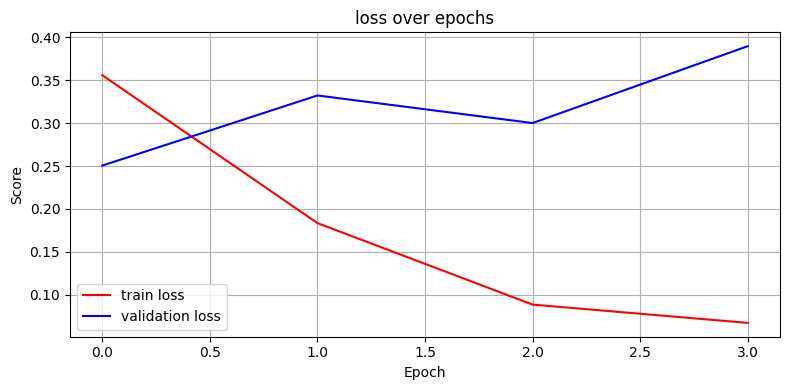

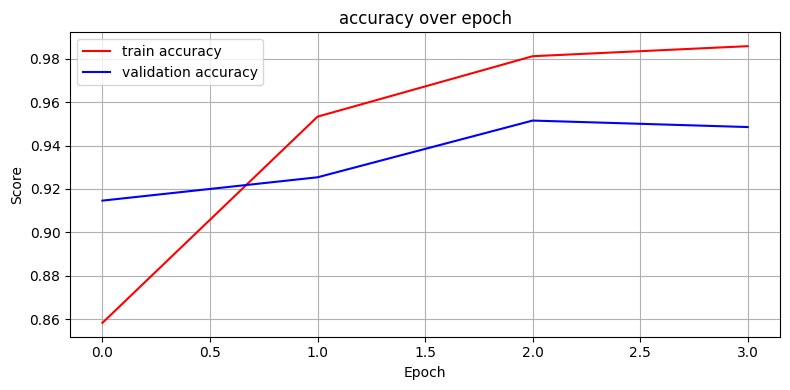

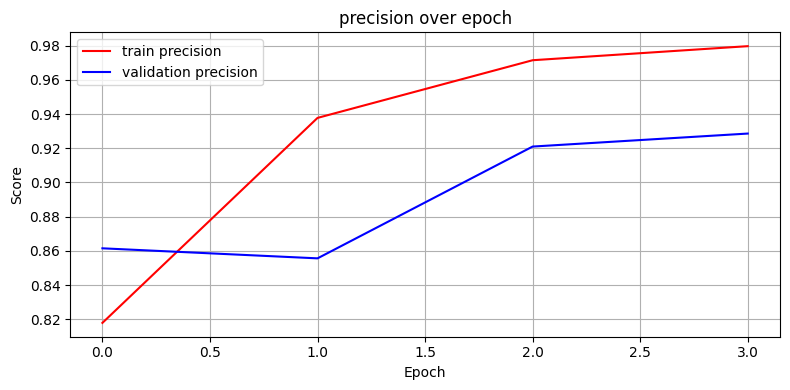

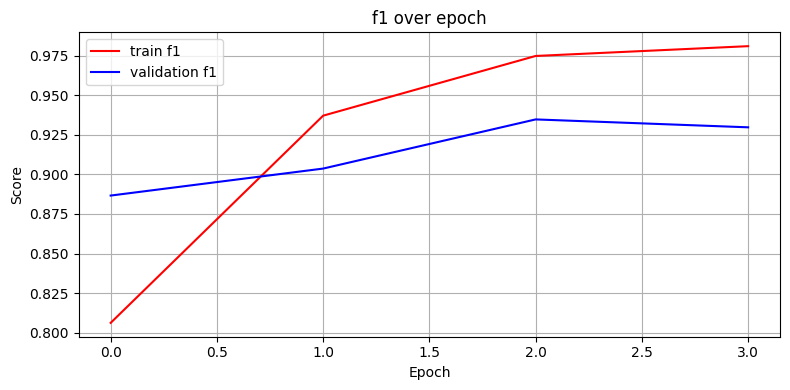

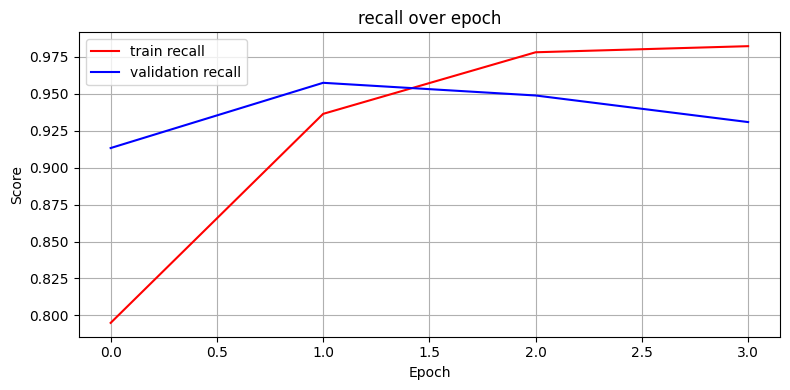

train loss: [0.35567482169000614, 0.18355647584246626, 0.0886991978593173, 0.06739927521872063]
validation loss: [0.25046865694701065, 0.33210453269096357, 0.2999943710223428, 0.38948273092819796]

=== Test Accuracy: 0.9072 ===

=== Test Precision: 0.8518 ===

=== Test f1: 0.8785 ===

=== Test recall: 0.9069 ===
              precision    recall  f1-score   support

           0       0.94      0.91      0.92      2342
           1       0.85      0.91      0.88      1375

    accuracy                           0.91      3717
   macro avg       0.90      0.91      0.90      3717
weighted avg       0.91      0.91      0.91      3717

Confusion Matrix:
 [[2125  217]
 [ 128 1247]]


In [ ]:
if __name__ == "__main__":
    import argparse
    from transformers import AutoModel, AutoTokenizer

    parser = argparse.ArgumentParser()
    parser.add_argument("--reddit_csv", type=str,
                        default=nielmirafuentes_exp_dataset_path)
    parser.add_argument("--epochs", type=int, default=6)
    parser.add_argument("--batch_size", type=int, default=8)
    parser.add_argument("--freeze_additional", choices=["yes","no"], default="yes")
    parser.add_argument("--max_length", type=int, default=128)
    parser.add_argument("--lr", type=float, default=2e-5)
    parser.add_argument("--show_visualizations", type=int, default=5)
    parser.add_argument("--seed", type=int, default=42)
    parser.add_argument("--cnn_filters", type=int, default=128)
    parser.add_argument("--cnn_dropout", type=float, default=0.4)
    parser.add_argument("--cnn_kernels", nargs='+', type=int, default=[2,3,4,5,6,7])
    parser.add_argument("--hatebert_model_name", type=str, default="GroNLP/HateBERT")
    parser.add_argument("--rationale_model_name", type=str, default="bert-base-uncased")

    args, _ = parser.parse_known_args()

    # Load models and tokenizers
    hatebert_model = AutoModel.from_pretrained(args.hatebert_model_name)
    rationale_model = AutoModel.from_pretrained(args.rationale_model_name)
    tokenizer_hatebert = AutoTokenizer.from_pretrained(args.hatebert_model_name)
    tokenizer_rationale = AutoTokenizer.from_pretrained(args.rationale_model_name)

    # Train and evaluate
    model = train_and_evaluate(
        reddit_csv_path=args.reddit_csv,
        hatebert_model=hatebert_model,
        rationale_model=rationale_model,
        tokenizer_hatebert=tokenizer_hatebert,
        tokenizer_rationale=tokenizer_rationale,
        epochs=args.epochs,
        batch_size=args.batch_size,
        freeze_rationale=(args.freeze_additional.lower() == "yes"),
        max_length=args.max_length,
        lr=args.lr,
        show_visualizations=args.show_visualizations,
        seed=args.seed,
        cnn_num_filters=args.cnn_filters,
        cnn_kernel_sizes=tuple(args.cnn_kernels),
        cnn_dropout=args.cnn_dropout
    )



In [ ]:
# download the mode\
save_path = f'/content/Base_Model_lr{args.lr}-bs8-wd00.pth'

torch.save({
'model_state_dict': model.state_dict(),
'model_config': {
    'cnn_num_filters': 128,
    'cnn_kernel_sizes': (2, 3, 4),
    'adapter_dim': 128,
    'max_length': 128
}
}, save_path)